<h1> <strong> <center> K-Nearest Neighbors </center> </strong> </h1>


### Introduction

In this assignment, you will be creating a K-Nearest Neighbors model from scratch.

This algorithm is one of the simpler ones you will come across, but the ideas can be applied to large-scale sophisticated systems: Semantic Search and Recommendation Systems for starters.

For this assignment, you will be creating your own KNN-classifier from scratch using `numpy`. You can then use this to classify images of *handwritten digits* from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

We will also be introduce a new type of nearest neighbor classifier later on. 

After this notebook you should be able to:

- Utilize `numpy` to implement a simple KNN classifier from scratch

- Understand how to setup a good Cross Validation strategy

- Be able to setup simple classification tasks

## Part 1: KNNs from Scratch

You are <span style="color: red;">not allowed</span> to use scikit-learn or any other machine learning toolkit for this part. You have to implement your own k-NN classifier from scratch.

### Importing Libraries
All of the necessary libraries for this part have been imported for you below. You may not use any other library apart from standard Python librares.

In [287]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics
import PIL
!pip install idx2numpy
import idx2numpy

### Task 1: Extracting the dataset
The MNIST dataset consists of 70,000 labeled images of handwritten digits, each of size 28 pixels by 28 pixels, yielding a total of 784 pixels per picture.

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This value ranges from 0-255

The dataset can be downloaded from [here](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) and is also available to in your assignment directory. The four relevant files in the folder are:
- train-images-idx3-ubyte: training set images
- train-labels-idx1-ubyte: training set labels
- t10k-images-idx3-ubyte: test set images
- t10k-labels-idx1-ubyte: test set labels

The dataset has been split with 60,000 images in the train set, and the remaning 10,000 images in the test set.

Your very first task is to to convert this dataset into a pandas dataframe.

Hint: *use the idx2numpy package to convert the dataset to a multidimensional numpy array. The documentation can be visited [here](https://pypi.org/project/idx2numpy/). The resulting array then has to be flattened.*

In [288]:
#Input file paths
train_images_path = 'train-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'
test_images_path = 't10k-images.idx3-ubyte'
test_labels_path = 't10k-labels.idx1-ubyte'

# Converting the idx files to numpy
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

# Printing the shape of the multidimensional array for both train and test set
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [289]:
# Flattening the array, appending the labels and printing the shape again 
# The shape of your train set should be (60000, 785), and test set should be (10000, 785)

train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)
print(f"Flattened Train set shape: {train_images_flattened.shape}")
print(f"Flattened Test set shape: {test_images_flattened.shape}")

train_data = np.hstack((train_images_flattened, train_labels.reshape(-1, 1)))
test_data = np.hstack((test_images_flattened, test_labels.reshape(-1, 1)))
print(f"Train set shape with labels: {train_data.shape}") 
print(f"Test set shape with labels: {test_data.shape}")    

Flattened Train set shape: (60000, 784)
Flattened Test set shape: (10000, 784)
Train set shape with labels: (60000, 785)
Test set shape with labels: (10000, 785)


QUESTION: What does each row of the dataset represents? 

ANSWER: Each row contains the flattened pixel values representing the image and the corresponding label.

### Task 2: Visualizing and preprocessing the dataset 

Now that we have a dataset to work with, we need to preprocess it further, before we pass it through our classifier. In this step, we will be seperating out the labels from the inputs, and attempt to standardize or normalize our dataset.

Note that the standardization of a variable $x$ refers to:
$$
x' = \frac{x - μ}{σ}
$$

where $μ$ is the mean of the variable and $σ$ is the standard deviation.

On the other hand, variable normalization usually involves scaling the data to a specific range.

You can read more about this [here](https://www.simplilearn.com/normalization-vs-standardization-article).

After you've loaded and split the dataset, let's display some images. You can reshape these 784 values for each image, into a `28x28` array, then use either `matplotlib` or `PIL` to display the image.

In [290]:
# Extracting labels and features 
train_x = train_data[:, :-1]
train_y = train_data[:, -1]
test_x = test_data[:, :-1]
test_y = test_data[:, -1]

print(f"Train set shape (features): {train_x.shape}")
print(f"Train set shape with labels: {train_y.shape}")
print(f"Train set shape with labels: {test_x.shape}")
print(f"Train set shape with labels: {test_y.shape}")

Train set shape (features): (60000, 784)
Train set shape with labels: (60000,)
Train set shape with labels: (10000, 784)
Train set shape with labels: (10000,)


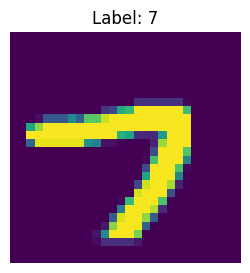

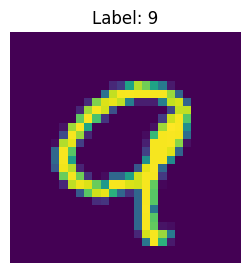

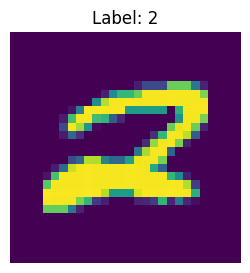

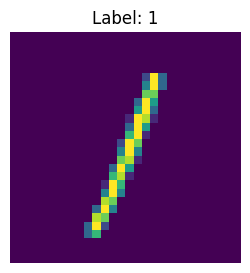

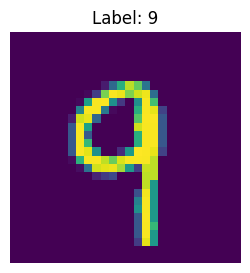

In [291]:
# Implementing a function to display images. The label is used as a title.

def display_image(features, label):
  '''
    Takes a 1D numpy array, reshapes to a 28x28 array and displays the image
  '''
  image = features.reshape(28, 28)
  plt.figure(figsize=(3, 3))
  plt.imshow(image, cmap='viridis')
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

for i in range(5):
    index = np.random.randint(0, train_x.shape[0]) 
    display_image(train_x[index], train_y[index])

In [292]:
# normalizing the data so that it falls in the [0, 1] range. 

def normalize(data):
  '''
    scales the data to the range [0, 1]
  '''
  normalized_data = (data)/(255)
  return normalized_data

train_x_normalized = normalize(train_x)
test_x_normalized = normalize(test_x)

QUESTION: With the variable standardization formula shown above in the description, is this technique feasible in this dataset? Explain in detail. 

ANSWER: 
- In the MNIST dataset, most of the pixels do not represent the digit itself, and thus do not contain truly meaningful information. They represent the background of the image and have values close to 0. Such sparsity in the dataset means that most pixels in most images are identical (0). Standardizing these pixels using a global mean and stdev, could obscure the information in the pixels that form the digit itself because in the MNIST dataset, the relevant information is more local and specific to each image. A global mean and stdev may not capture the variability in digit shapes effectively because they are averaged over many images with varying digits.
	

### Task 3: Implementing k-NN Classifier 

Now you can create your own k-NN classifier. You can use the following steps as a guide:

1. For a test data point, find its distance from all training instances.

2. Sort the calculated distances in ascending order based on distance values.

3. Choose k training samples with minimum distances from the test data point.

4. Return the *most frequent* class of these samples.

For values of `k` where a tie occurs, you need to break the tie by backing off to the `k-1` value. In case there is still a tie, you will continue decreasing `k` until there is a clear winner.

#### Important

**Note:** Your function should work with *Euclidean* distance as well as *Manhattan* distance. Pass the distance metric as a parameter in the k-NN classifier function. Your function should also let one specify the value of `k`.

#### Distance functions

Implement separate functions for the Euclidean and Manhattan distances. Formulas for both are given below.

$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$

$$
d_{\text{Manhattan}}(\vec{p},\vec{q}) = |(p_1 - q_1)| + |(p_2 - q_2)| + |(p_3 - q_3)| + ... + |(p_n - q_n)|
$$

In [293]:
class KNN:
  
  def __init__(self, k):
    '''
      Initializes the class
    '''
    self.k = k
    self.train_x = None
    self.train_y = None


  def euclidean_distance(self, x1, x2): 
 
    return (np.sqrt(np.sum((np.power((x1 - x2), 2)), axis= 1)))


  def manhattan_distance(self, x1, x2): 
 
    return (np.sum((np.abs(x1 - x2)), axis= 1))


  def fit(self, train_x, train_y): 

    self.train_x = train_x
    self.train_y = train_y


  def get_neighbors(self, new_point, distancefunc): 

    distances = distancefunc(self.train_x, new_point)
    neighbour_indices = np.argsort(distances)[:self.k]
    neighbours = self.train_y[neighbour_indices]
    return neighbours


  def predict(self, test_x, distancefunc): 
    
    predictions = []
        
    for i, new_point in enumerate(test_x):
      k_value = self.k

      while k_value > 0:
        neighbours = self.get_neighbors(new_point, distancefunc)
        majority_classes = statistics.multimode(neighbours[:k_value])

        if len(majority_classes) == 1:
          majority_label = majority_classes[0]
          predictions.append(majority_label)
          break
        
        else:
          k_value = k_value - 1
      
      if k_value == 0:
        majority_label = neighbours[0]
        predictions.append(majority_label)
        
    return np.array(predictions)

### Task 4: Evaluation 

Now that you've created a model and "trained" it, you can move on to the Evaluation phase.

- We will be implementing an `evaluate` function that computes the Confusion Matrix, Accuracy, and Macro-Average F1 score of your classifier. You can use multiple helper functions to calculate the individual metrics.

- The function should take as input the predicted labels and the true labels. This will be built in steps: its easier to create a Confusion Matrix, then calculate things like the Precision, Recall and F1 from it.

- We will also implement a function that displays our confusion matrix as a heatmap annotated with the data values.
- The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.

Complete the following functions:

- `accuracy`
- `make_confusion_matrix`
- `make_heat_map`
- `precision`
- `recall`
- `f1_score`
- `macro_average_f1`
- `evaluate`

In [294]:
def accuracy(predicted_labels, true_labels): 

  accuracy = np.mean(predicted_labels == true_labels)
  return accuracy


def make_confusion_matrix(predicted_labels, true_labels):

    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
    num_classes = len(unique_labels)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for i in range(len(true_labels)):
        predicted_label = int(predicted_labels[i])
        true_label = int(true_labels[i])
        confusion_matrix[predicted_label][true_label] += 1
    
    return confusion_matrix
  
  
def make_heat_map(confusion_matrix, title): 

  plt.figure(figsize=(12, 6))
  sns.heatmap(confusion_matrix, fmt="d", annot= True, cmap= "Blues", cbar= True)
  plt.title(title)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.show()


def precision(confusion_matrix, class_label): 
  
  tp = confusion_matrix[class_label, class_label]
  fp = np.sum(confusion_matrix[class_label, :]) - tp
  predicted_positives = np.sum(confusion_matrix[class_label, :])   
   
  if predicted_positives == 0:
    return 0.0
  
  precision = (tp)/(tp + fp)
  return precision


def recall(confusion_matrix, class_label): 
 
  tp = confusion_matrix[class_label, class_label]  
  fn = np.sum(confusion_matrix[:, class_label]) - tp

  total_actual_positives = np.sum(confusion_matrix[:, class_label])
    
  if total_actual_positives == 0:
    return 0.0
  
  recall = (tp)/(tp + fn)
  return recall

  
def f1_score(precision, recall): 

  if precision + recall == 0:
    return 0.0
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  return f1_score


def macro_average_f1(confusion_matrix): 

  num_classes = confusion_matrix.shape[0]
  precisions = [precision(confusion_matrix, i) for i in range(num_classes)]
  recalls = [recall(confusion_matrix, i) for i in range(num_classes)]
  f1_scores = [f1_score(precisions[i], recalls[i]) for i in range(num_classes)]

  return np.mean(f1_scores)


def evaluate(predicted_labels, true_labels): 
  '''
    Displays and returns a nicely formatted report with accuracy, macro-average f1 score, and confusion matrix
  '''
  confusion_matrix_result = make_confusion_matrix(predicted_labels, true_labels)
  accuracy_value = accuracy(predicted_labels, true_labels)
  macro_f1 = macro_average_f1(confusion_matrix_result)    
      
  report = f"Confusion Matrix:\n{confusion_matrix_result} \nAccuracy: {accuracy_value * 100:.2f}%\nMacro-Average F1 Score: {macro_f1:.2f}\n"
     
  return confusion_matrix_result, report    

### Task 5: k-fold Cross Validation:


Now with the basics done, you can move on to the next step: k-fold Cross Validation. This is a more robust way of evaluating your model since it uses all the data for training and testing (effectively giving you `k` chances to verify the generalizability of your model).

Now, implement a function that performs `k`-fold cross-validation on the training data for a specified value of `k`.

In Cross Validation, you divide the dataset into `k` parts. `k-1` parts will be used for training and `1` part will be used for validation. You will repeat this process `k` times, each time using a different part for validation. You will then average the results of each fold to get the final result. Take a look at the image above for a better understanding.

The function should return **predictions** for the **entire training data** (size of list/array should be equal to the size of the dataset). This is the result of appending the predicted labels for each validation-train split into a single list/array. Make sure the order of the predicted labels matches the order of the training dataset, so that they may directly be passed to your `evaluate` function together with the actual labels.

---

Complete the following functions:

- `k_fold_split`
- `k_fold_cross_validation`

In [295]:
def k_fold_split(num_folds, cv_no, train_x, train_y): 
    '''
    Creates the train and test splits based off the value of k

    Parameters
    ----------
    mum_folds : int
        Number of folds
    cv_no : int
        The current fold number
    train_x : nparray
        The features
    train_y : nparray
        The labels
    '''
    fold_size = train_x.shape[0] // num_folds
    
    start_i = cv_no * fold_size
    end_i = start_i + fold_size
    
    validation_fold_x = train_x[start_i : end_i]
    validation_fold_y = train_y[start_i : end_i]
    
    train_fold_x = np.concatenate((train_x[:start_i], train_x[end_i:]), axis= 0)
    train_fold_y = np.concatenate((train_y[:start_i], train_y[end_i:]), axis= 0)
    
    return train_fold_x, train_fold_y, validation_fold_x, validation_fold_y


def k_fold_cross_validation(num_folds, k, train_x, train_y, distanceFunction): 
    """
    Returns the predictions for all the data points in the dataset using k-fold cross validation

    num_folds: int
      Number of folds
    k: int
      Number of neighbours to consider (hyperparameter)
    train_x : nparray
        The features
    train_y : nparray
        The labels
    distanceFunction : str
        Distance metric specified (manhattan / euclidean)
    """
    
    predictions = np.zeros(train_y.shape)
    
    for i in range(num_folds):
        train_fold_x, train_fold_y, validation_fold_x, validation_fold_y = k_fold_split(num_folds, i, train_x, train_y)
        
        knn = KNN(k= k)
        knn.fit(train_fold_x, train_fold_y)
        
        if distanceFunction == 'euclidean':
            dF = knn.euclidean_distance
        elif distanceFunction == 'manhattan':
            dF = knn.manhattan_distance
        else:
            raise ValueError("Invalid distance function. Choose from either 'euclidean' or 'manhattan'")
        
        fold_predictions = knn.predict(validation_fold_x, dF)
        
        fold_size = validation_fold_x.shape[0]
        start_val_i = i * fold_size
        predictions[start_val_i : start_val_i + fold_size] = fold_predictions
        
    return predictions

Now run your cross-validation function on the training data using `5-fold cross validation` for the values of `k = [1, 2, 3, 4, 5]`.

Do this for both the Euclidean distance and the  Manhattan distance for each value of `k`.

Also run your evaluation function for each value of `k` (for both distance metrics) and print out the classification accuracy and F1 score.

**Note: Save your evaluation stats for plotting later**

In [296]:
accuracy_list_euclidean = []
f1_list_euclidean = []
accuracy_list_manhattan = []
f1_list_manhattan = []

data = np.hstack((train_x_normalized, train_y.reshape(-1, 1)))
np.random.seed(42)  
sampled_data = data[np.random.choice(data.shape[0], 14000, replace=False)]
sampled_train_x = sampled_data[:, :-1]
sampled_train_y = sampled_data[:, -1]

k_values = [1, 2, 3, 4, 5]
num_folds = 5

In [297]:
print("\nResults for Euclidean distances: ")
for k in k_values:
    print(f"\nCross-Validation for k = {k} ")
    predictions_Euclidean = k_fold_cross_validation(num_folds, k, sampled_train_x, sampled_train_y, 'euclidean')
    confusion_matrix_Euclidean, report_Euclidean = evaluate(predictions_Euclidean, sampled_train_y)
    print(report_Euclidean)
    accuracy_list_euclidean.append(accuracy(predictions_Euclidean, sampled_train_y))  
    f1_list_euclidean.append(macro_average_f1(confusion_matrix_Euclidean)) 


Results for Euclidean distances: 

Cross-Validation for k = 1 
Confusion Matrix:
[[1366    0   13    2    3    9    9    3    5    5]
 [   0 1511   16    3   12    6    8   19   12    4]
 [   4    4 1307   17    1    0    0    2    8    2]
 [   1    0   11 1328    0   24    0    1   35   10]
 [   0    1    3    0 1288    0    2    6    9   32]
 [   3    0    1   28    0 1218   10    0   26    3]
 [   5    3    2    0    2   19 1352    0   10    1]
 [   1    1   21    7    9    4    0 1459    5   32]
 [   1    0    3   20    0    6    1    2 1226    3]
 [   3    1    1   14   52    8    0   16   21 1298]] 
Accuracy: 95.38%
Macro-Average F1 Score: 0.95


Cross-Validation for k = 2 
Confusion Matrix:
[[1366    0   13    2    3    9    9    3    5    5]
 [   0 1511   16    3   12    6    8   19   12    4]
 [   4    4 1307   17    1    0    0    2    8    2]
 [   1    0   11 1328    0   24    0    1   35   10]
 [   0    1    3    0 1288    0    2    6    9   32]
 [   3    0    1   28    0 

In [298]:
print("\nResults for Manhattan distances: ")
for k in k_values:
    print(f"\nCross-Validation for k = {k} ")
    predictions_Manhattan = k_fold_cross_validation(num_folds, k, sampled_train_x, sampled_train_y, 'manhattan')
    confusion_matrix_Manhattan, report_Manhattan = evaluate(predictions_Manhattan, sampled_train_y)
    print(report_Manhattan)
    accuracy_list_manhattan.append(accuracy(predictions_Manhattan, sampled_train_y))  
    f1_list_manhattan.append(macro_average_f1(confusion_matrix_Manhattan)) 


Results for Manhattan distances: 

Cross-Validation for k = 1 
Confusion Matrix:
[[1362    0   18    4    3   10    9    3    5    4]
 [   0 1509   30    5   14   11    8   27   20    6]
 [   4    4 1270   17    1    0    0    2   15    3]
 [   1    0   12 1315    1   27    0    1   39    8]
 [   0    1    2    0 1282    3    2    5    9   34]
 [   4    0    2   30    0 1206   10    0   41    4]
 [   8    3    5    2    2   20 1352    0   10    1]
 [   1    3   34   10   11    4    0 1457   11   50]
 [   1    0    3   21    0    5    1    1 1185    5]
 [   3    1    2   15   53    8    0   12   22 1275]] 
Accuracy: 94.38%
Macro-Average F1 Score: 0.94


Cross-Validation for k = 2 
Confusion Matrix:
[[1362    0   18    4    3   10    9    3    5    4]
 [   0 1509   30    5   14   11    8   27   20    6]
 [   4    4 1270   17    1    0    0    2   15    3]
 [   1    0   12 1315    1   27    0    1   39    8]
 [   0    1    2    0 1282    3    2    5    9   34]
 [   4    0    2   30    0 

Next, present the results as a graph with `k` values on the x-axis and classification accuracy on the y-axis. Use a single plot to compare the two versions of the classifier (one using Euclidean and the other using Manhattan distance metric).

Make another graph but with the F1-score on the y-axis this time. The graphs should be properly labeled on axes, with a title, and a legend.

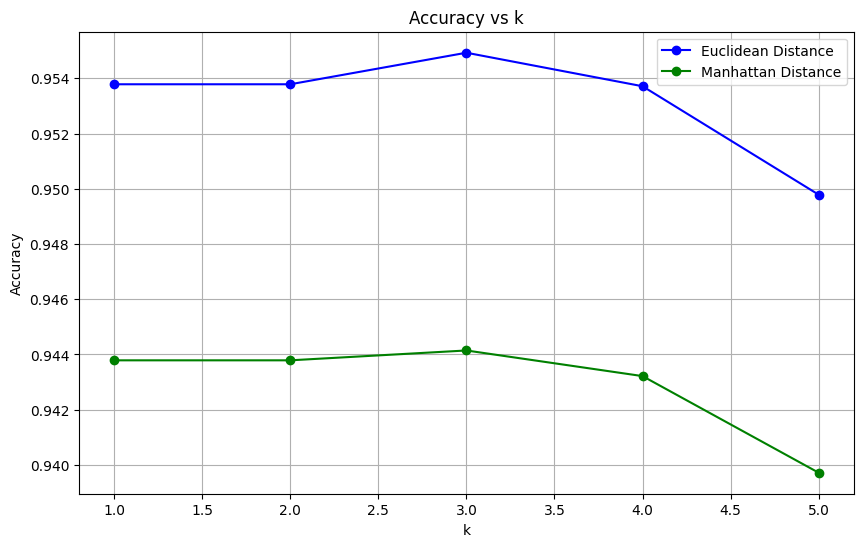

In [299]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_list_euclidean, marker='o', label='Euclidean Distance', color='blue')
plt.plot(k_values, accuracy_list_manhattan, marker='o', label='Manhattan Distance', color='green')

plt.title('Accuracy vs k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

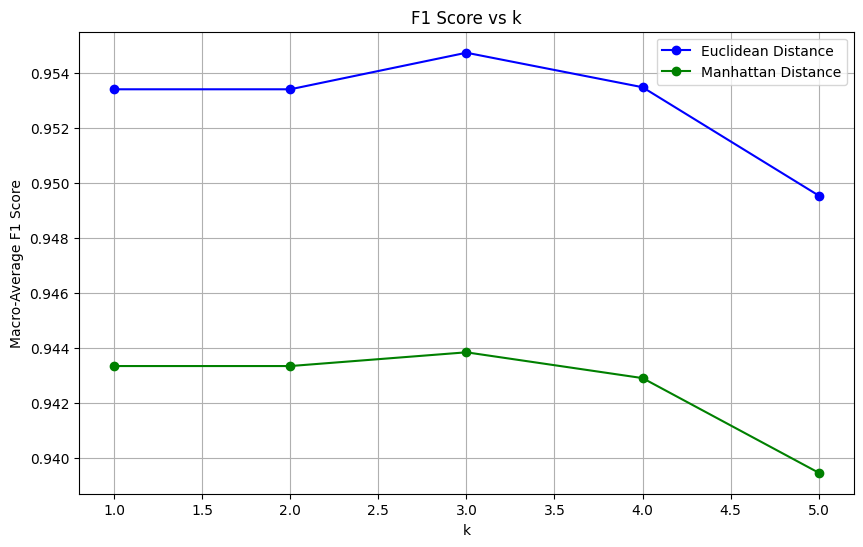

In [300]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_list_euclidean, marker='o', label='Euclidean Distance', color='blue')
plt.plot(k_values, f1_list_manhattan, marker='o', label='Manhattan Distance', color='green')

plt.title('F1 Score vs k')
plt.xlabel('k')
plt.ylabel('Macro-Average F1 Score')
plt.legend()
plt.grid(True)

plt.show()

### Task 6: Prediction:

Finally, use the best value of `k` for both distance metrics and run it on the test dataset.

Find the confusion matrix, classification accuracy and F1 score and print them.

The confusion matrix must be displayed as a heatmap annotated with the data values. 

Euclidean Distance: 

Confusion Matrix:
[[ 974    0    9    0    0    4    4    0    7    3]
 [   1 1133    7    1    5    1    3   18    0    4]
 [   1    2  997    4    0    0    0    4    3    2]
 [   0    0    2  975    0   12    0    0   13    7]
 [   0    0    0    1  948    2    4    2    5    9]
 [   1    0    0   13    0  860    3    0   11    4]
 [   2    0    1    1    5    5  944    0    3    1]
 [   1    0   14    7    4    1    0  994    4    8]
 [   0    0    2    4    1    3    0    0  923    2]
 [   0    0    0    4   19    4    0   10    5  969]] 
Accuracy: 97.17%
Macro-Average F1 Score: 0.97



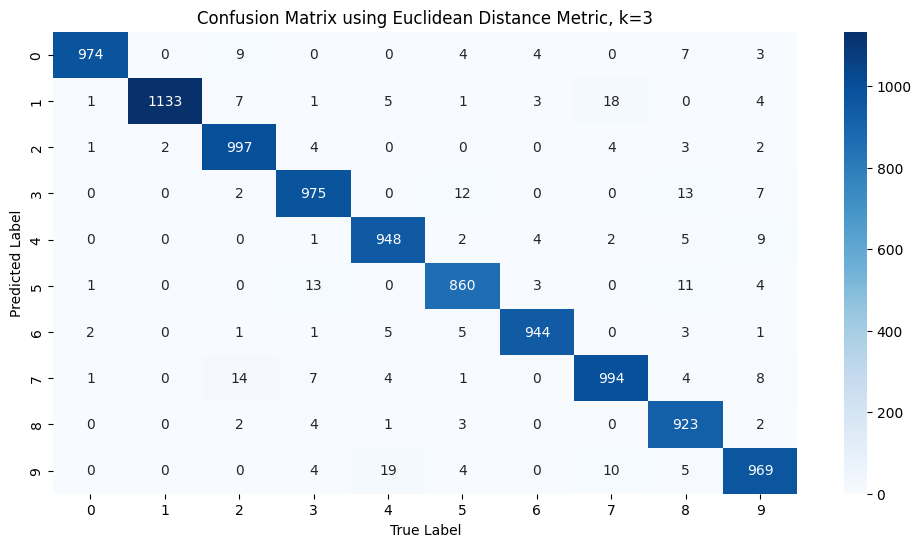

In [301]:
# Testing with the best K for euclidean distance 

print("Euclidean Distance: \n")

best_k_euclidean = k_values[np.argmax(accuracy_list_euclidean)]
knn_euclidean = KNN(k= best_k_euclidean)
knn_euclidean.fit(train_x_normalized, train_y)
predictions_euclidean_test = knn_euclidean.predict(test_x_normalized, knn_euclidean.euclidean_distance)

confusion_matrix_euclidean_test, report_euclidean_test = evaluate(predictions_euclidean_test, test_y)

print(report_euclidean_test)
make_heat_map(confusion_matrix_euclidean_test, f'Confusion Matrix using Euclidean Distance Metric, k={best_k_euclidean}')

Manhattan Distance 

Confusion Matrix:
[[ 974    0   10    0    1    5    6    0   11    2]
 [   1 1134   12    3   12    1    3   24    4    7]
 [   1    1  982    4    0    0    0    4    4    1]
 [   0    0    3  971    0    9    0    0   19    6]
 [   0    0    1    1  934    2    4    2    6   10]
 [   1    0    0   15    0  858    3    0   15    4]
 [   2    0    2    0    6    6  942    0    4    1]
 [   1    0   18    9    5    1    0  989    5   18]
 [   0    0    4    4    0    2    0    0  898    2]
 [   0    0    0    3   24    8    0    9    8  958]] 
Accuracy: 96.40%
Macro-Average F1 Score: 0.96



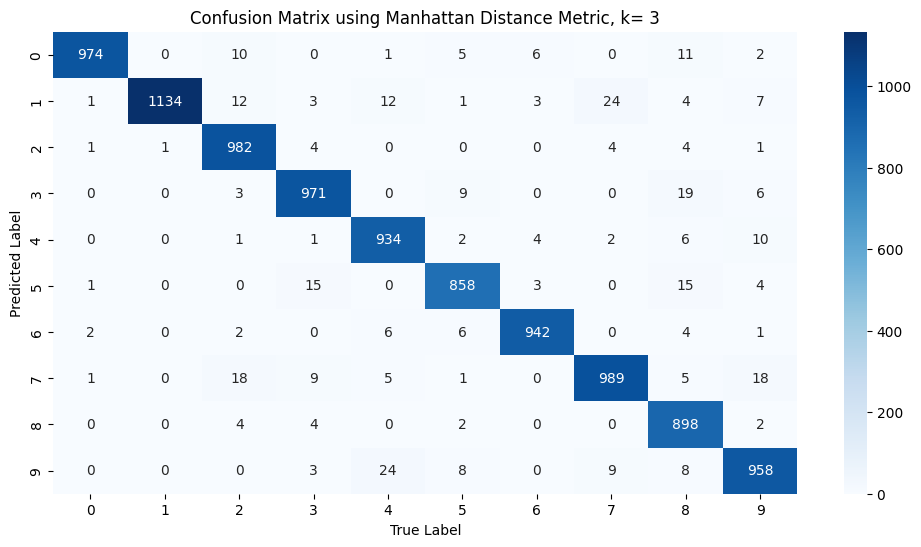

In [302]:
# Testing with the best K for Manhattan distance

print(f"Manhattan Distance \n")

best_k_manhattan = k_values[np.argmax(accuracy_list_manhattan)]
knn_manhattan = KNN(k= best_k_manhattan)
knn_manhattan.fit(train_x_normalized, train_y)
predictions_manhattan_test = knn_manhattan.predict(test_x_normalized, knn_manhattan.manhattan_distance)

confusion_matrix_manhattan_test, report_manhattan_test = evaluate(predictions_manhattan_test, test_y)

print(report_manhattan_test)
make_heat_map(confusion_matrix_manhattan_test, f'Confusion Matrix using Manhattan Distance Metric, k= {best_k_manhattan}')

## Part 2: KNN using Scikit-Learn

In this part, you have to use [scikit-learn's k-NN implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to train and test your classifier on the dataset used in Part 1. Repeat the tasks you have done in Part 1 but this time using scikit-learn.

- Use the best value of `k` from part 1 for both manhattan and euclidean distance. You don't need to perform k-fold cross validation this time

- Use scikit-learn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function to calculate the accuracy, the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to calculate macro-average F1 score,
and the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to calculate confusion matrix from the predicted labels.

**NOTE: Use the preprocessed dataset from Part 1**

In [303]:
!pip install scikit-learn==1.4.2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Test Accuracy (Euclidean, k=3): 97.05%
Macro-Average F1 Score (Euclidean, k=3): 0.97


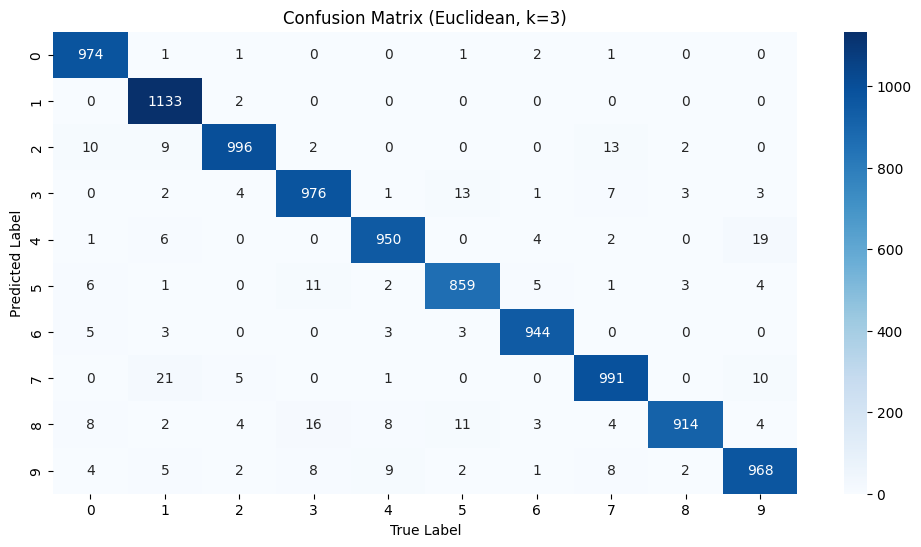

In [304]:
best_k_euclidean_sklearn = k_values[np.argmax(accuracy_list_euclidean)]

knn_euclidean_sklearn = KNeighborsClassifier(n_neighbors= best_k_euclidean, metric= 'euclidean')
knn_euclidean_sklearn.fit(train_x_normalized, train_y)
predictions_euclidean_sklearn = knn_euclidean_sklearn.predict(test_x_normalized)

accuracy_euclidean_sklearn = accuracy_score(test_y, predictions_euclidean_sklearn)
print(f"Test Accuracy (Euclidean, k={best_k_euclidean}): {accuracy_euclidean_sklearn * 100:.2f}%")

classification_report_euclidean = classification_report(test_y, predictions_euclidean_sklearn, output_dict=True)
f1_euclidean_sklearn = classification_report_euclidean['macro avg']['f1-score']
print(f"Macro-Average F1 Score (Euclidean, k={best_k_euclidean_sklearn}): {f1_euclidean_sklearn:.2f}")

confusion_matrix_euclidean_sklearn = confusion_matrix(test_y, predictions_euclidean_sklearn)
make_heat_map(confusion_matrix_euclidean_sklearn, f'Confusion Matrix (Euclidean, k={best_k_euclidean})')

Test Accuracy (Manhattan, k=3): 96.33%
Macro-Average F1 Score (Manhattan, k=3): 0.96


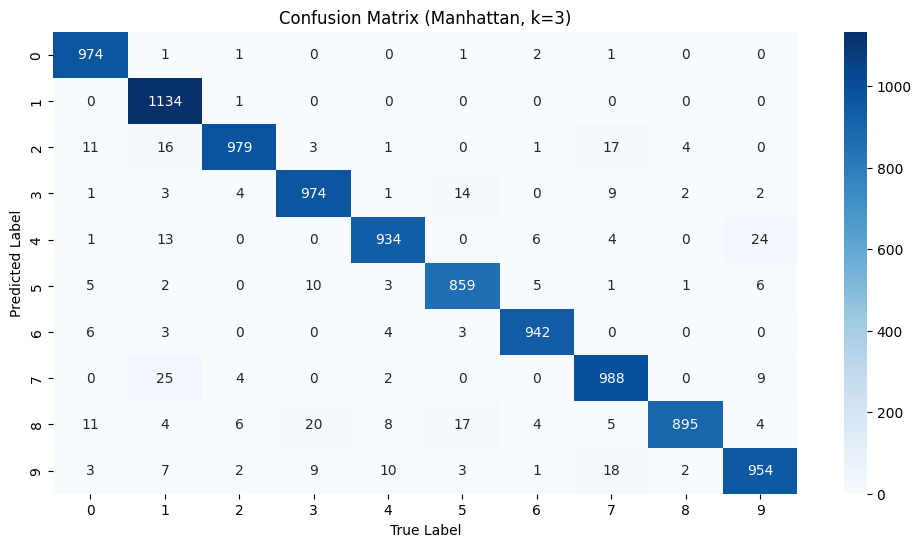

In [305]:
best_k_manhattan_sklearn = k_values[np.argmax(accuracy_list_manhattan)]

knn_manhattan_sklearn = KNeighborsClassifier(n_neighbors=best_k_manhattan, metric='manhattan')
knn_manhattan_sklearn.fit(train_x_normalized, train_y)
predictions_manhattan_sklearn = knn_manhattan_sklearn.predict(test_x_normalized)

accuracy_manhattan_sklearn = accuracy_score(test_y, predictions_manhattan_sklearn)
print(f"Test Accuracy (Manhattan, k={best_k_manhattan}): {accuracy_manhattan_sklearn * 100:.2f}%")

classification_report_manhattan = classification_report(test_y, predictions_manhattan_sklearn, output_dict=True)
f1_manhattan_sklearn = classification_report_manhattan['macro avg']['f1-score']
print(f"Macro-Average F1 Score (Manhattan, k={best_k_manhattan_sklearn}): {f1_manhattan_sklearn:.2f}")

confusion_matrix_manhattan_sklearn = confusion_matrix(test_y, predictions_manhattan_sklearn)

make_heat_map(confusion_matrix_manhattan_sklearn, f'Confusion Matrix (Manhattan, k={best_k_manhattan})')

## Part 3: Radius nearest neighbors

Radius Neighbors Classifier is an extension to the k-nearest neighbors algorithm that makes predictions using all examples in the radius of a new example rather than the k-closest neighbors. Read more about this neighbor-based classifier [here](https://machinelearningmastery.com/radius-neighbors-classifier-algorithm-with-python/#:~:text=Radius%20Neighbors%20Classifier%20is%20a,than%20the%20k%2Dclosest%20neighbors.).

The Radius Neighbors Classifier is similar to KNN in respect that its training involves storing the entire training dataset. However, instead of basing decisions on k-nearest neighbors, the Radius Neighbors Classifier locates all examples in the training dataset that are within a given radius of the new example to make a prediction.

For this part, we will be using the [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset).

Task 1: Data Loading and Preprocessing 

The breast cancer dataset comprises of 569 rows and 32 columns. Your task is to design a r-NN classifier that is able to classify breast tumors into malignant (cancerous) or benign (non cancerous).  

In [306]:
# Reading the dataset into a pandas dataframe, displaying its shape, and its first 5 rows 

df = pd.read_csv('breast-cancer.csv')
print(df.shape)
print(df.head(5))

(569, 32)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst

In [307]:
# Dropping the id column 
df.drop(columns=['id'], inplace= True)

# Replacing the dataset labels with their numeric counterparts: M->1, B->0 
df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})

/var/folders/5l/z_f8vl_56236dtty6zj589g00000gn/T/ipykernel_1879/416653631.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})


In [308]:
# Randomly sampling 80% of the dataset for train dataset and retaining the remaining 20% for test dataset 
df = df.sample(frac= 1, random_state=42).reset_index(drop= True)
split = int(0.8 * len(df))

RNN_train_data = df[:split]
RNN_test_data = df[split:]

# splitting features from labels 
RNN_train_x = RNN_train_data.drop(columns=['diagnosis'])
RNN_train_y = RNN_train_data['diagnosis']
RNN_test_x = RNN_test_data.drop(columns= ['diagnosis'])
RNN_test_y = RNN_test_data['diagnosis']

# Printing the shape of train_x, train_y, test_x, test_y
print(RNN_train_x.shape)
print(RNN_train_y.shape)
print(RNN_test_x.shape)
print(RNN_test_y.shape)

(455, 30)
(455,)
(114, 30)
(114,)


In [309]:
# Converting dataframes to numpy array
RNN_train_x = np.array(RNN_train_x)
RNN_train_y = np.array(RNN_train_y)
RNN_test_x = np.array(RNN_test_x)
RNN_test_y = np.array(RNN_test_y)

# standardizing features in test and train sets 

mean = RNN_train_x.mean(axis=0)
stdev = RNN_train_x.std(axis=0)

RNN_train_x = (RNN_train_x - mean) / stdev
RNN_test_x = (RNN_test_x - mean) / stdev

print(f"Mean of standardized train_x: {RNN_train_x.mean(axis=0)}")
print(f"Standard deviation of standardized train_x: {RNN_train_x.std(axis=0)}")

Mean of standardized train_x: [ 1.83491805e-16  3.02566275e-16  2.34244858e-17 -2.49861182e-16
  3.06470356e-16  2.61573425e-16  5.07530526e-17  1.14194368e-16
  7.88624355e-16  1.21416918e-15  1.97156089e-16 -3.26966781e-17
 -1.30786712e-16 -1.22978550e-16  2.14724453e-16 -7.41775383e-17
  9.76020241e-17 -1.01506105e-16 -2.34244858e-16  5.56331538e-17
  1.36642834e-16  1.35666814e-16  1.21026510e-16 -1.40546915e-16
 -1.71779562e-16  2.92806072e-17 -7.32015181e-17  5.85612145e-17
  5.46571335e-17  6.83214169e-16]
Standard deviation of standardized train_x: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [310]:
print(RNN_train_x.shape)
print(RNN_train_y.shape)
print(RNN_test_x.shape)
print(RNN_test_y.shape)

(455, 30)
(455,)
(114, 30)
(114,)


### Task 2: Implementing r-NN Classifier 

You are now fully equipped to create your own radius nearest neighbor classifier. You can use the following steps as a guide:

- For a test data point, find its distance from all training instances.

- Sort the calculated distances in ascending order based on distance values.

- Choose all of the training examples that are within the radius `r`

- Return the most frequent class of these samples.

**Note:** Sometimes for the radius `r`, it is possible that you will not have any training examples in the given radius for some test data points. In this case, simply return the **majority class** of the dataset.

On the other hand, if there is a tie, you can use a similar strategy as before. Remove the furthest training example from your choosen neighbors to take a vote.

Complete the following methods:
- `euclidean_distance`
- `manhattan_distance`
- `fit`                
- `get_neighbors`      
- `predict`

In [311]:
class RNN:

  def __init__(self, r):
    '''
      Initializes the class
    '''
    self.r = r
    self.train_x = None
    self.train_y = None


  def euclidean_distance(self, x1, x2): 
        
    return np.sqrt(np.sum(np.power((x1 - x2), 2), axis= 1))
  

  def manhattan_distance(self, x1, x2): 
    
    return np.sum(np.abs(x1 - x2), axis= 1)

  def fit(self, train_x, train_y):
    
    self.train_x = train_x
    self.train_y = train_y
 

  def get_neighbors(self, new_point, distancefunc): 
    '''
      Takes a new point and returns the nearest neighbors within the radius r
      Hint: Sort the distances by their index to get the labels easily
    '''
    distances = distancefunc(self.train_x, new_point)
    neighbor_indices = np.where(distances <= self.r)[0]
    neighbors = self.train_y[neighbor_indices]
    return neighbors


  def predict(self, test_x, distancefunc): 
    '''
      Takes a test set and returns the predicted labels
    '''
    majority_class = np.bincount(self.train_y).argmax()
    predictions = np.zeros(len(test_x), dtype= int)
    
    for i, point in enumerate(test_x):
      neighbors = self.get_neighbors(point, distancefunc)
      
      if len(neighbors) == 0:
        predictions[i] = majority_class
      else:
        neighbor_labels = self.train_y[neighbors]
        predictions[i] = np.bincount(neighbor_labels).argmax()
    
    return predictions

### Task 3: k-fold Cross Validation 

In this part, for **euclidean distance**, uniformally sample **20** different values of `r` from the range `3.5-5.5`. Use these values of `r` for 5-fold cross validation using the functions you implemented in part 1.

For **manhattan distance** uniformally sample **20** different values of `r` from the range `15.5-17.5`. Use these values of `r` for 5-fold cross validation using the functions you implemented in part 1.

Again, for each `r`, conduct the cross validation for both distances and report accuracy and macro-f1 score for each `r` and distance. You can use sklearn evaluation metrics to report the results

**Store these results for plotting later.**

In [312]:
def k_fold_cross_validation_rnn(num_folds, r, train_x, train_y, distanceFunction):
  """
    Returns the predictions for all the data points in the dataset using k-fold cross validation

    num_folds: int
      Number of folds
    r: float
      Radius of neighbours to consider (hyperparameter)
    train_x: np array
      The dataset features to be used
    test_x: np array
      The dataset labels to be used
    distancefunc: str
      The distance function to be used
    """
    
  predictions = np.zeros(len(train_x), dtype= int)
  
  rnn = RNN(r)
  
  if distanceFunction == 'euclidean':
    dF = rnn.euclidean_distance
  elif distanceFunction == 'manhattan':
    dF = rnn.manhattan_distance
  else:
    raise ValueError("Invalid distance function. Choose from either Euclidean or Manhattan.")
  
  for i in range(num_folds):
    train_fold_x, train_fold_y, validation_fold_x, validation_fold_y = k_fold_split(num_folds, i, train_x, train_y)
    
    rnn.fit(train_fold_x, train_fold_y)
    fold_predictions = rnn.predict(validation_fold_x, dF)
    
    x = i * len(validation_fold_x)
    y = (i + 1) * len(validation_fold_x)
    
    predictions[x:y] = fold_predictions
  
  return predictions

In [313]:
accuracy_list_euclidean = []
f1_list_euclidean = []
accuracy_list_manhattan = []
f1_list_manhattan = []

r_values_euclidean = np.linspace(3.5, 5.5, 20)
r_values_manhattan = np.linspace(15.5, 17.5, 20)

print(f"Sampled r values for Euclidean: {r_values_euclidean}")
print(f"Sampled r values for Manhattan: {r_values_manhattan}")

Sampled r values for Euclidean: [3.5        3.60526316 3.71052632 3.81578947 3.92105263 4.02631579
 4.13157895 4.23684211 4.34210526 4.44736842 4.55263158 4.65789474
 4.76315789 4.86842105 4.97368421 5.07894737 5.18421053 5.28947368
 5.39473684 5.5       ]
Sampled r values for Manhattan: [15.5        15.60526316 15.71052632 15.81578947 15.92105263 16.02631579
 16.13157895 16.23684211 16.34210526 16.44736842 16.55263158 16.65789474
 16.76315789 16.86842105 16.97368421 17.07894737 17.18421053 17.28947368
 17.39473684 17.5       ]


In [314]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [315]:
num_folds = 5

for r in r_values_euclidean:
    predictions = k_fold_cross_validation_rnn(num_folds, r, RNN_train_x, RNN_train_y, 'euclidean')
    
    accuracy = accuracy_score(RNN_train_y, predictions)
    f1 = f1_score(RNN_train_y, predictions, average= 'macro')
    
    accuracy_list_euclidean.append(accuracy)
    f1_list_euclidean.append(f1)
    
r_values_euclidean = np.sort(r_values_euclidean)

for i in range(len(r_values_euclidean)):
    r = r_values_euclidean[i]
    a = accuracy_list_euclidean[i]
    f1 = f1_list_euclidean[i]
    print(f"{i+1}: r = {r:.4f}, accuracy = {a * 100:.2f}%, macro f1 = {f1:.3f}")

1: r = 3.5000, accuracy = 83.30%, macro f1 = 0.792
2: r = 3.6053, accuracy = 83.52%, macro f1 = 0.796
3: r = 3.7105, accuracy = 83.74%, macro f1 = 0.799
4: r = 3.8158, accuracy = 83.96%, macro f1 = 0.802
5: r = 3.9211, accuracy = 84.84%, macro f1 = 0.815
6: r = 4.0263, accuracy = 85.27%, macro f1 = 0.822
7: r = 4.1316, accuracy = 85.27%, macro f1 = 0.822
8: r = 4.2368, accuracy = 85.27%, macro f1 = 0.822
9: r = 4.3421, accuracy = 85.71%, macro f1 = 0.828
10: r = 4.4474, accuracy = 85.49%, macro f1 = 0.825
11: r = 4.5526, accuracy = 85.05%, macro f1 = 0.818
12: r = 4.6579, accuracy = 85.05%, macro f1 = 0.818
13: r = 4.7632, accuracy = 85.27%, macro f1 = 0.821
14: r = 4.8684, accuracy = 85.27%, macro f1 = 0.821
15: r = 4.9737, accuracy = 85.49%, macro f1 = 0.824
16: r = 5.0789, accuracy = 85.49%, macro f1 = 0.824
17: r = 5.1842, accuracy = 85.71%, macro f1 = 0.827
18: r = 5.2895, accuracy = 85.71%, macro f1 = 0.827
19: r = 5.3947, accuracy = 85.71%, macro f1 = 0.827
20: r = 5.5000, accur

In [316]:
for r in r_values_manhattan:
    predictions = k_fold_cross_validation_rnn(num_folds, r, RNN_train_x, RNN_train_y, 'manhattan')
    
    accuracy = accuracy_score(RNN_train_y, predictions)
    f1 = f1_score(RNN_train_y, predictions, average= 'macro')
    
    accuracy_list_manhattan.append(accuracy)
    f1_list_manhattan.append(f1)
    
r_values_manhattan = np.sort(r_values_manhattan)

for i in range(len(r_values_manhattan)):
    r = r_values_manhattan[i]
    a = accuracy_list_manhattan[i]
    f1 = f1_list_manhattan[i]
    print(f"{i+1}: r = {r:.4f}, accuracy = {a * 100:.2f}%, macro f1 = {f1:.3f}")

1: r = 15.5000, accuracy = 84.18%, macro f1 = 0.805
2: r = 15.6053, accuracy = 83.96%, macro f1 = 0.803
3: r = 15.7105, accuracy = 83.74%, macro f1 = 0.800
4: r = 15.8158, accuracy = 83.96%, macro f1 = 0.803
5: r = 15.9211, accuracy = 83.96%, macro f1 = 0.803
6: r = 16.0263, accuracy = 84.40%, macro f1 = 0.810
7: r = 16.1316, accuracy = 84.40%, macro f1 = 0.810
8: r = 16.2368, accuracy = 84.62%, macro f1 = 0.813
9: r = 16.3421, accuracy = 84.84%, macro f1 = 0.815
10: r = 16.4474, accuracy = 84.84%, macro f1 = 0.815
11: r = 16.5526, accuracy = 84.62%, macro f1 = 0.812
12: r = 16.6579, accuracy = 84.40%, macro f1 = 0.810
13: r = 16.7632, accuracy = 84.40%, macro f1 = 0.809
14: r = 16.8684, accuracy = 84.62%, macro f1 = 0.812
15: r = 16.9737, accuracy = 84.84%, macro f1 = 0.815
16: r = 17.0789, accuracy = 84.84%, macro f1 = 0.815
17: r = 17.1842, accuracy = 85.05%, macro f1 = 0.819
18: r = 17.2895, accuracy = 85.05%, macro f1 = 0.819
19: r = 17.3947, accuracy = 85.05%, macro f1 = 0.819
20

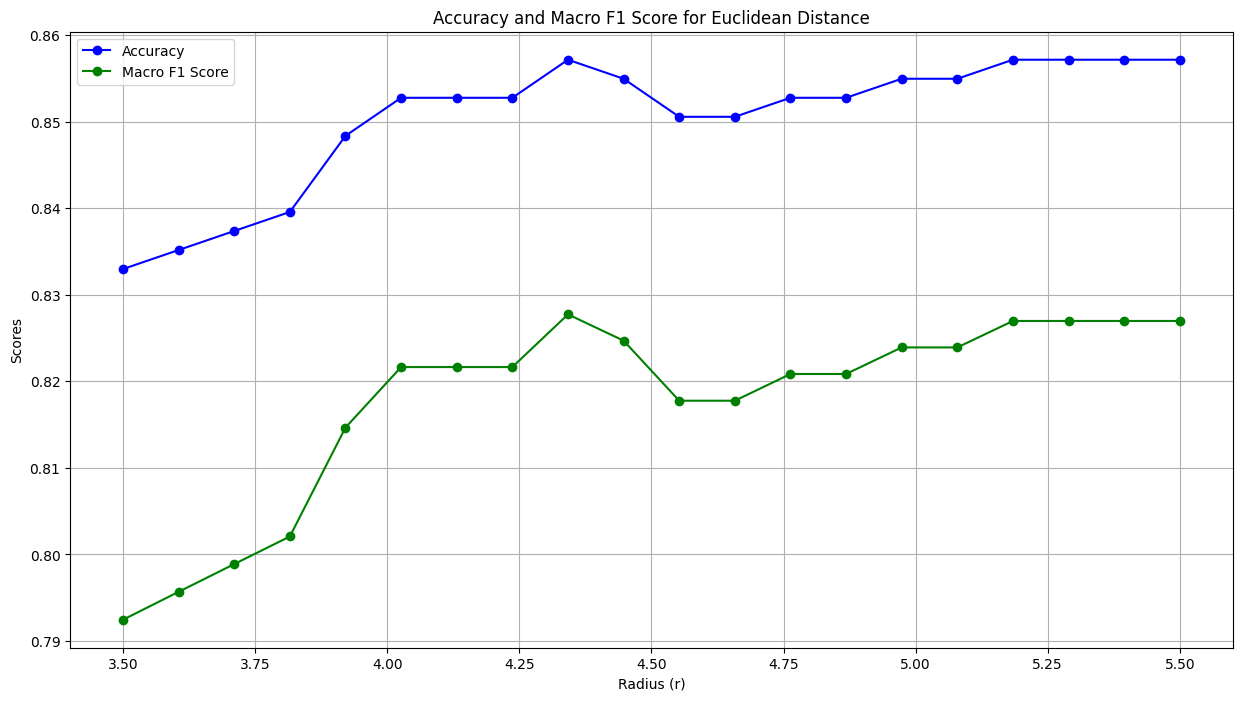

In [317]:
plt.figure(figsize=(15, 8))

plt.plot(r_values_euclidean, accuracy_list_euclidean, label='Accuracy', marker='o', color='blue', linestyle='-')
plt.plot(r_values_euclidean, f1_list_euclidean, label='Macro F1 Score', marker='o', color='green', linestyle='-')

plt.xlabel('Radius (r)')
plt.ylabel('Scores')
plt.title('Accuracy and Macro F1 Score for Euclidean Distance')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

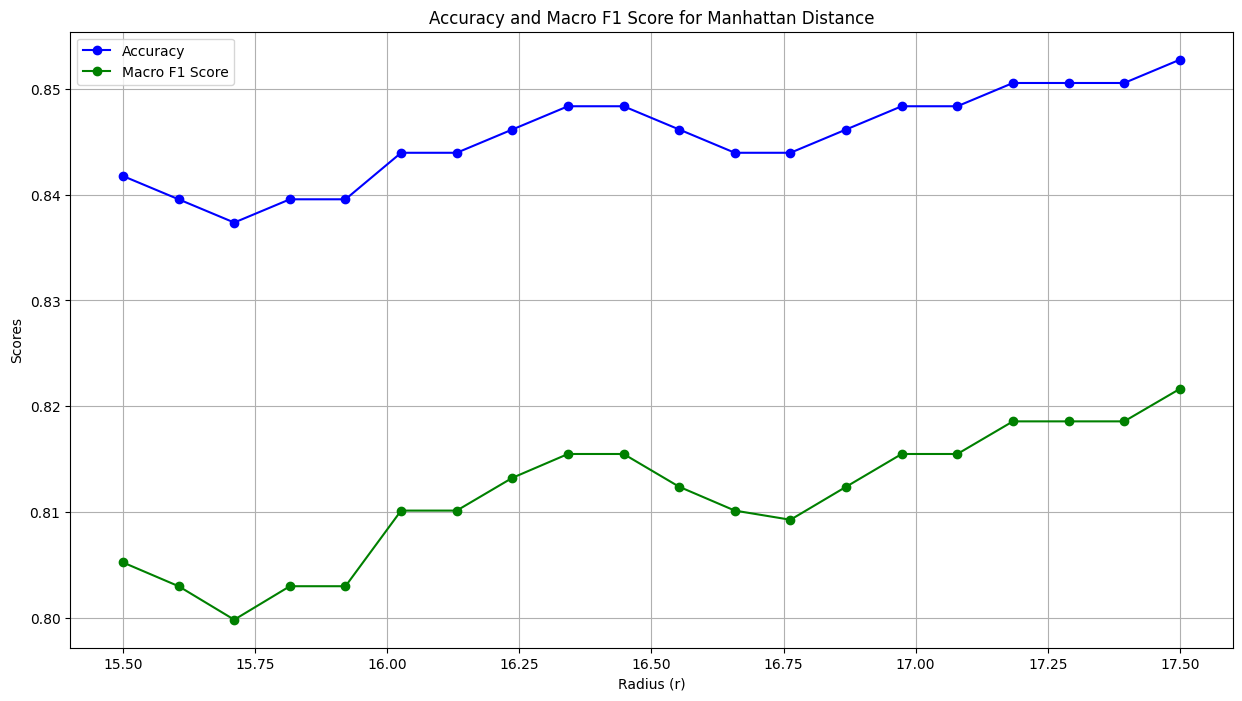

In [318]:
plt.figure(figsize=(15, 8))

plt.plot(r_values_manhattan, accuracy_list_manhattan, label='Accuracy', marker='o', color='blue', linestyle='-')
plt.plot(r_values_manhattan, f1_list_manhattan, label='Macro F1 Score', marker='o', color='green', linestyle='-')

plt.xlabel('Radius (r)')
plt.ylabel('Scores')
plt.title('Accuracy and Macro F1 Score for Manhattan Distance')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

QUESTION: Discuss how the value of `r` relates to overfitting and underfitting. 


Answer: 

- A very small value of r means that only a few neighbors are considered when making predictions. This can lead to overfitting, as the model may become too sensitive to local variations in the training data. 

- A very large value of r means that more neighbors are considered for making predictions. This can lead to underfitting if r is excessively large. The model may fail to capture important local patterns in the data, resulting in a model that cannot differentiate between classes very well.

### Task 4: Prediction 

Finally, use the best value of `r` for both distance metrics and run it on the test dataset. 

Find the confusion matrix, classification accuracy and macro F1 score and print them. You can use Sklearn's evaluation metrics in this part as well.

The confusion matrix must be displayed as a heatmap annotated with the data values. 

Best value of r for Euclidean Distance:  4.342105263157895

Accuracy = 87.72%, Macro F1 = 0.865


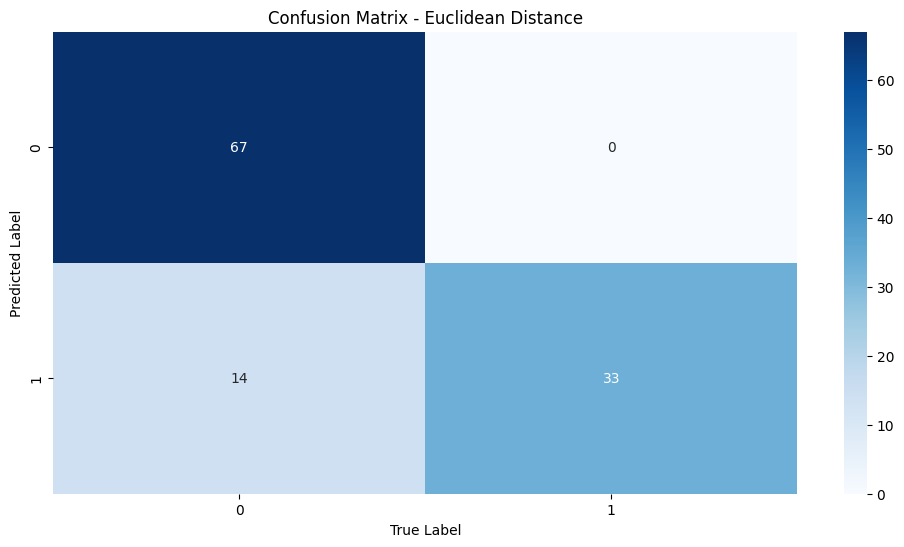

In [319]:
best_r_euclidean = r_values_euclidean[np.argmax(accuracy_list_euclidean)]
print("Best value of r for Euclidean Distance: ", best_r_euclidean)
rnn_euclidean = RNN(best_r_euclidean)
rnn_euclidean.fit(RNN_train_x, RNN_train_y)
predictions_euclidean_rnn = rnn_euclidean.predict(RNN_test_x, rnn_euclidean.euclidean_distance)

confusion_matrix_euclidean_rnn = confusion_matrix(RNN_test_y, predictions_euclidean_rnn)
accuracy_euclidean = accuracy_score(RNN_test_y, predictions_euclidean_rnn)
f1_euclidean = f1_score(RNN_test_y, predictions_euclidean_rnn, average='macro')
print(f"\nAccuracy = {accuracy_euclidean * 100:.2f}%, Macro F1 = {f1_euclidean:.3f}")

make_heat_map(confusion_matrix_euclidean_rnn, "Confusion Matrix - Euclidean Distance")

Best value of r for Manhattan Distance:  17.5

Accuracy = 88.60%, Macro F1 = 0.876


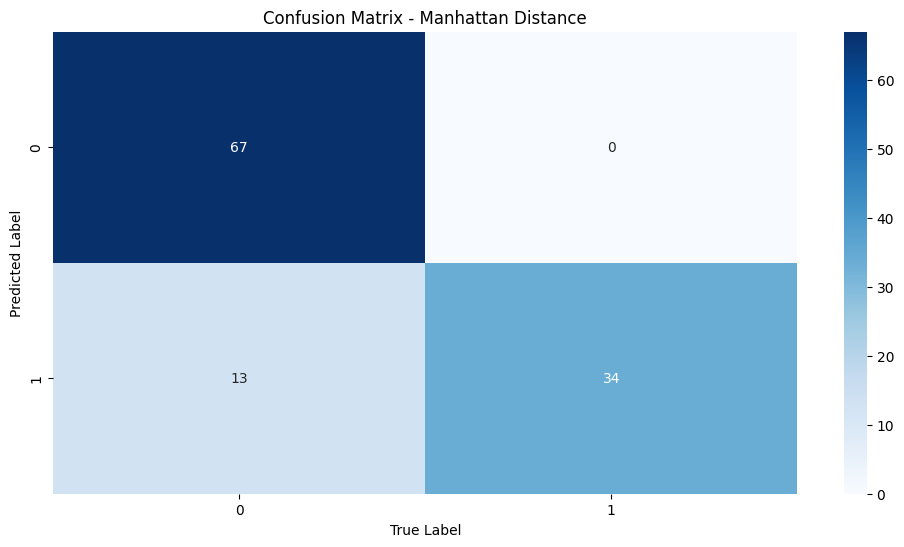

In [320]:
best_r_manhattan = r_values_manhattan[np.argmax(accuracy_list_manhattan)]
print("Best value of r for Manhattan Distance: ", best_r_manhattan)

rnn_manhattan = RNN(best_r_manhattan)
rnn_manhattan.fit(RNN_train_x, RNN_train_y)
predictions_manhattan_rnn = rnn_manhattan.predict(RNN_test_x, rnn_manhattan.manhattan_distance)

confusion_matrix_manhattan_rnn = confusion_matrix(RNN_test_y, predictions_manhattan_rnn)
accuracy_manhattan = accuracy_score(RNN_test_y, predictions_manhattan_rnn)
f1_manhattan = f1_score(RNN_test_y, predictions_manhattan_rnn, average='macro')
print(f"\nAccuracy = {accuracy_manhattan * 100:.2f}%, Macro F1 = {f1_manhattan:.3f}")

make_heat_map(confusion_matrix_manhattan_rnn, "Confusion Matrix - Manhattan Distance")

QUESTION: Explain why rNN classifier would have been a poor choice for the MNIST dataset. Discuss with respect to curse of dimentionality.

Answer:
The rNN classifier would have been a poor choice for the MNIST dataset because it is a high-dimensional dataset, containing images of handwritten digits.
In high-dimensional spaces, the 'nearest' neighbours become increasingly spaced away from each other, leading to a situation where most points are approximately equidistant from one another. This makes it difficult for RNN to identify the 'nearest' neighbours based on a distance (i.e the radius). Also, for distance-based methods like rNN, we need a larger number of data to fill the high-dimensional space. However, the rNN dataset contains only a mere 569 datapoints, which is not sufficient enough.